## Задание
1. Выбрать датасет, подходящий для моделирования рекомендательной системы.  Хорошие источники данных: https://ods.ai/competitions/ и https://www.recsyschallenge.com/2024/ (тут можно подставлять любой год, начиная с 2016). Ещё примеры данных: https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge#dataset и https://boosters.pro/championship/rekko_challenge/data
2. Сделать разведочный анализ данных, то есть посчитать статистические показатели, построить визуализации и дать им интерпретацию, подготовить отчёт по качеству данных (пропуски, дубли, выбросы). При необходимости предобработать данные. Сделать выводы.
3. Выбрать минимум три метода формирования рекомендации. Реализовать их. Потенциальные методы: MostPop, UserKNN, ItemKNN, SLIM, EASE, ALS
4. Выбрать несколько метрик оценки качества рекомендаций. Рассчитать их. Желательно выбирать хотя бы одну метрику, учитывающую качество ранжирования.
5. Желательно выбрать хотя бы одну специфическую для рекомендательных систем метрику (новизна, разнообразие, неожиданность)
Сформулировать предложения по улучшению качества рекомендаций. Сделать выводы.

## Для выполнения был выбран один из competition от MTS:
### Вам предоставлены данные из приложения МТС Kion по взаимодействиям пользователей с контентом за период 6 месяцев.
    В отдельных файлах есть:

* факты просмотра контента пользователями
* описание контента
* описание пользователей

Что нужно сделать?
Наиболее качественно порекомендовать список из 10 объектов для каждого пользователя из тестовой выборки.

### Ссылка на competition: https://ods.ai/competitions/competition-recsys-21

In [1]:
!pip install more_itertools

In [2]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import stanza
from itertools import islice, cycle
from more_itertools import pairwise

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from IPython.core.display import display, HTML, clear_output
display(HTML('<style>.container { width:80% !important; }</style>'))
display(HTML('<style>.prompt { min-width:10ex !important; }</style>'))
display(HTML('<style>div#notebook { font-size:12px !important; }</style>'))

/var/folders/pq/7p0c971j5k7dd6zbzt4kxsj40000gn/T/ipykernel_4943/3403949601.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML, clear_output
/var/folders/pq/7p0c971j5k7dd6zbzt4kxsj40000gn/T/ipykernel_4943/3403949601.py:16: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML, clear_output


In [3]:
stanza.download('ru')

2025-02-24 19:56:37 INFO: Downloaded file to /Users/maksvell/stanza_resources/resources.json
2025-02-24 19:56:37 INFO: Downloading default packages for language: ru (Russian) ...
2025-02-24 19:56:38 INFO: File exists: /Users/maksvell/stanza_resources/ru/default.zip
2025-02-24 19:56:40 INFO: Finished downloading models and saved to /Users/maksvell/stanza_resources


# Обзор датасета онлайн-кинотеатра Kion

Датасет содержит информацию о пользователях, контенте (фильмы/сериалы) и их взаимодействиях за период примерно 6 месяцев, с 2021-03-13 по 2021-08-22. Данные включают анонимизированные идентификаторы пользователей и контента, а также случайный шум.

## Статистика датасета

- **Пользователи:** 840,000
- **Объекты контента:** 16,000
- **Взаимодействия:** 5,500,000

## Описание файлов

### `users.csv`

Этот файл содержит информацию о пользователях:

- **`user_id`**: Идентификатор пользователя
- **`age`**: Возрастная группа пользователя в формате "M_N"
  - `18_24`: от 18 до 24 лет
  - `25_34`: от 25 до 34 лет
  - `35_44`: от 35 до 44 лет
  - `45_54`: от 45 до 54 лет
  - `55_64`: от 55 до 64 лет
  - `65_inf`: 65 и старше
- **`sex`**: Пол пользователя
  - `M`: Мужчина
  - `Ж`: Женщина
- **`income`**: Уровень дохода пользователя в формате "M_N"
  - `income_0_20`
  - `income_20_40`
  - `income_40_60`
  - `income_60_90`
  - `income_90_150`
  - `income_150_inf`
- **`kids_flg`**: Флаг наличия детей

### `items.csv`

Этот файл содержит информацию о контенте (фильмы/сериалы):

- **`item_id`**: Идентификатор контента
- **`content_type`**: Тип контента (фильм, сериал)
- **`title`**: Название на русском языке
- **`title_orig`**: Оригинальное название
- **`genres`**: Жанры из источника (онлайн-кинотеатры)
- **`countries`**: Страны происхождения
- **`for_kids`**: Флаг "контент для детей"
- **`age_rating`**: Возрастной рейтинг
- **`studios`**: Студии, участвовавшие в создании
- **`directors`**: Режиссеры
- **`actors`**: Актеры
- **`keywords`**: Ключевые слова
- **`description`**: Описание контента

### `interactions.csv`

Этот файл содержит информацию о взаимодействиях пользователей с контентом:

- **`user_id`**: Идентификатор пользователя
- **`item_id`**: Идентификатор контента
- **`last_watch_dt`**: Дата последнего просмотра
- **`total_dur`**: Общая продолжительность всех просмотров данного контента в секундах
- **`content_type`**: Тип контента (фильм, сериал)

Этот датасет предоставляет всесторонний взгляд на поведение пользователей и предпочтения контента в онлайн-кинотеатре Kion за указанный период.

# 2. EDA

## Users

In [6]:
users_df = pd.read_csv('users.csv')

In [7]:
users_df.sample(5)

,user_id,age,income,sex,kids_flg
146233,790265,age_25_34,income_20_40,Ж,0
692842,125435,age_18_24,income_20_40,Ж,0
828885,769214,age_25_34,income_40_60,М,0
652233,548474,age_18_24,income_0_20,Ж,0
352202,63493,age_45_54,income_20_40,Ж,0


In [8]:
users_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


In [9]:
users_df.nunique()

user_id     840197
age              6
income           6
sex              2
kids_flg         2
dtype: int64

In [10]:
users_df.shape

(840197, 5)

In [11]:
users_df.isnull().sum()

user_id         0
age         14095
income      14776
sex         13831
kids_flg        0
dtype: int64

<Axes: xlabel='age'>

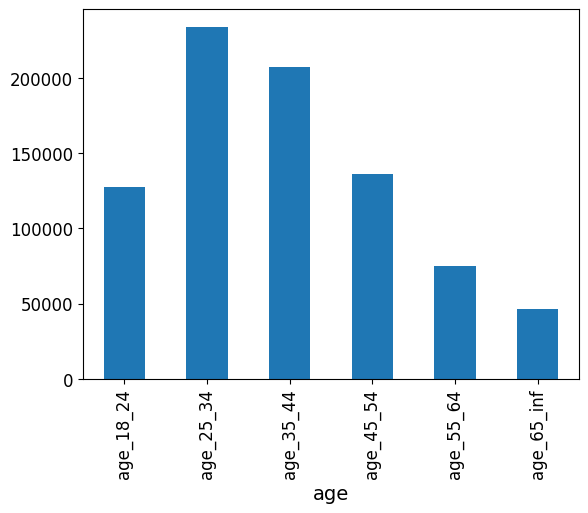

In [12]:
users_df.age.value_counts().sort_index().plot(kind='bar')

In [13]:
users_df['age'] = users_df['age'].fillna('age_unknown')

In [14]:
users_df['age'].value_counts()

age
age_25_34      233926
age_35_44      207043
age_45_54      135925
age_18_24      127672
age_55_64       75265
age_65_inf      46271
age_unknown     14095
Name: count, dtype: int64

In [15]:
users_df.income.value_counts()

income
income_20_40      471519
income_40_60      248330
income_60_90       68674
income_0_20        21836
income_90_150      13985
income_150_inf      1077
Name: count, dtype: int64

<Axes: xlabel='income'>

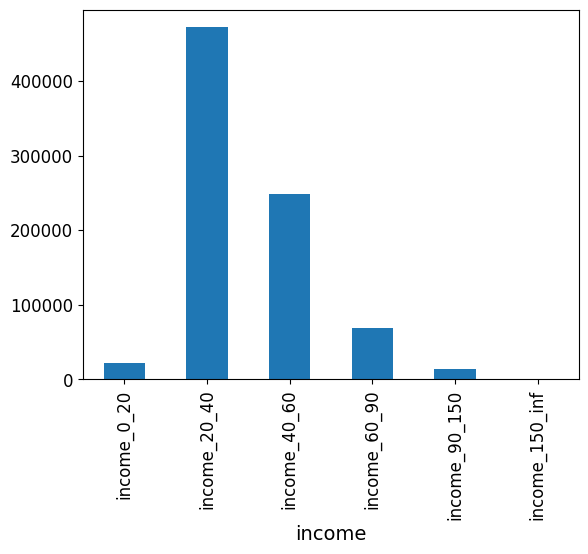

In [16]:
users_df.income.value_counts().iloc[[3,0,1,2,4,5]].plot(kind='bar')

In [17]:
users_df['income'] = users_df['income'].fillna('income_unknown')

In [18]:
users_df['income'].value_counts()

income
income_20_40      471519
income_40_60      248330
income_60_90       68674
income_0_20        21836
income_unknown     14776
income_90_150      13985
income_150_inf      1077
Name: count, dtype: int64

In [19]:
users_df['sex'].value_counts()

sex
Ж    425270
М    401096
Name: count, dtype: int64

In [20]:
users_df['sex'] = users_df['sex'].fillna('sex_unknown')

In [21]:
users_df['sex'] = users_df['sex'].map({'М': 1, 'Ж': 0, 'sex_unknown': 2})

In [22]:
users_df['sex'].value_counts()

sex
0    425270
1    401096
2     13831
Name: count, dtype: int64

In [23]:
users_df['kids_flg'].value_counts()

kids_flg
0    587209
1    252988
Name: count, dtype: int64

In [24]:
users_df['kids_flg'] = users_df['kids_flg'].astype('bool')

In [25]:
users_df.duplicated(subset=['user_id'], keep=False).sum()

np.int64(0)

In [26]:
from sklearn.preprocessing import OrdinalEncoder

age_order = ['age_unknown', 'age_18_24', 'age_25_34', 'age_35_44', 'age_45_54', 'age_55_64', 'age_65_inf']
income_order = ['income_unknown', 'income_0_20', 'income_20_40', 'income_40_60', 'income_60_90', 'income_90_150', 'income_150_inf']

encoder = OrdinalEncoder(categories=[age_order, income_order])

users_df[['age', 'income']] = encoder.fit_transform(users_df[['age', 'income']])

In [27]:
users_df.sample(5)

,user_id,age,income,sex,kids_flg
755330,15540,1.0,2.0,0,True
29182,586887,1.0,2.0,0,False
446928,184009,2.0,3.0,0,True
453335,696393,6.0,2.0,0,False
114142,38422,3.0,4.0,1,True


In [28]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   840197 non-null  int64  
 1   age       840197 non-null  float64
 2   income    840197 non-null  float64
 3   sex       840197 non-null  int64  
 4   kids_flg  840197 non-null  bool   
dtypes: bool(1), float64(2), int64(2)
memory usage: 26.4 MB


## Items

In [30]:
items_df = pd.read_csv('items.csv')

In [31]:
items_df.sample(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
3869,5485,film,Посмешище,Ridicule,2011.0,"драмы, комедии",Франция,NaN,6.0,NaN,"Одри Наджар, Фридерик Перро","Ромен Селье, Даниэль Берлиу, Лайонел Эммери, Ш...",Ромен всегда чувствовал себя по-другому по оче...,"2011, франция, посмешище"
9501,8308,series,Принцесса Фантагира,FANTAGHIRO,1999.0,мультсериалы,Испания,NaN,6.0,NaN,Тони Гарсиа,NaN,Великолепный мультипликационный сериал для дет...,NaN
13667,12966,film,Собеседование,Entretien d'embauche,2015.0,"драмы, фэнтези, комедии",Франция,NaN,12.0,NaN,Николас Новак,"Джозеф Эрнандез, Бенжамин Вангермее, Изабель К...",Молодой выпускник приходит на классическое соб...,"2015, франция, собеседование"
15773,10029,series,Сын за отца,NaN,2014.0,"драмы, криминал",Россия,0.0,16.0,NaN,Леван Когуашвили,"Антон Макарский, Алексей Горбунов, Татьяна Лют...",Вадиму с детства прививали мораль и нравственн...,"Сын, за, отца, 2014, Россия"
4172,5866,film,Долина Синих скал,Valley of the Blue Rocks,1956.0,"драмы, русские",СССР,NaN,12.0,NaN,Николай Красий,"Леонид Жуковский, Федор Радчук, Андрей Сова, А...",Молодой геолог Василий Рубан сразу после оконч...,"Долина, Синих, скал, 1956, СССР"


In [32]:
items_df.shape

(15963, 14)

In [33]:
items_df.nunique()

item_id         15963
content_type        2
title           15293
title_orig      10575
release_year      105
genres           2771
countries         687
for_kids            2
age_rating          6
studios            38
directors        7973
actors          12996
description     15619
keywords        15492
dtype: int64

In [34]:
items_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


In [35]:
items_df.content_type.value_counts()

content_type
film      12002
series     3961
Name: count, dtype: int64

In [36]:
items_df.content_type.isnull().sum()

np.int64(0)

In [37]:
items_df['content_type'] = items_df['content_type'].map({'film': 1, 'series': 0})

In [38]:
items_df['title'].sample(5)

13827       Рей и пожарный патруль
8797                      Бумбараш
9305                        Нико 2
3852     Русское краткое. Выпуск 4
14039      Труффальдино из Бергамо
Name: title, dtype: object

In [39]:
items_df.duplicated(subset=['title'], keep=False).sum()

np.int64(1266)

In [40]:
items_df['title'] = items_df['title'].str.lower()

In [41]:
items_df.title.value_counts()

title
охота                                   5
соблазн                                 4
стрелок                                 4
вторжение                               4
родина                                  4
                                       ..
война по принуждению                    1
море соблазна                           1
сексуальные эксперименты в космосе 2    1
голый романтик                          1
гоша                                    1
Name: count, Length: 15276, dtype: int64

In [42]:
items_df.loc[items_df.title == 'охота']

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
1190,9103,1,охота,"Hunt, The",2020.0,"боевики, триллеры, комедии",США,NaN,18.0,NaN,Крэйг Зобел,"Бетти Гилпин, Хилари Суэнк, Айк Баринхолц, Уэй...",Несколько человек имели неосторожность обсужда...,"хорватия, охота на людей, ручная граната, свин..."
3447,1223,0,охота,NaN,2019.0,"драмы, зарубежные",Австралия,NaN,18.0,NaN,"Ана Коккинос, Софи Хайд","Алекс Кьюсак, Ашер Кедди, Джессика Де Гау, Кав...",В обычной австралийской школе разгорается секс...,"Охота, 2019, Австралия, отцы, дети, первая, лю..."
10851,5692,1,охота,Jagten,2012.0,"драмы, зарубежные",Дания,NaN,16.0,NaN,Томас Винтерберг,"Александра Рапапорт, Аллан Вибор Кристенсен, А...",Борющийся с трудностями и одиночеством детский...,"Охота, 2012, Дания, безответная, любовь, друзь..."
10934,15114,1,охота,The Hunting,2017.0,"драмы, зарубежные, триллеры, ужасы",США,NaN,18.0,NaN,NaN,NaN,Действие мрачного триллера разворачивается в 1...,"Охота, 2017, США, друзья, страхи, убийства, уб..."
13446,7891,1,охота,The hunt,2019.0,"драмы, мультфильм",Польша,NaN,16.0,NaN,Матеуш Ярмульски,NaN,Во время летних каникул в сельской местности 1...,"2019, польша, охота"


In [43]:
items_df.title.isnull().sum()

np.int64(0)

In [44]:
items_df['title_orig'].sample(5)

9310     Les auto-entrepreneuses
2529              Tropic Thunder
7768                         NaN
10232               Little Gobie
13617                        NaN
Name: title_orig, dtype: object

<Axes: xlabel='countries'>

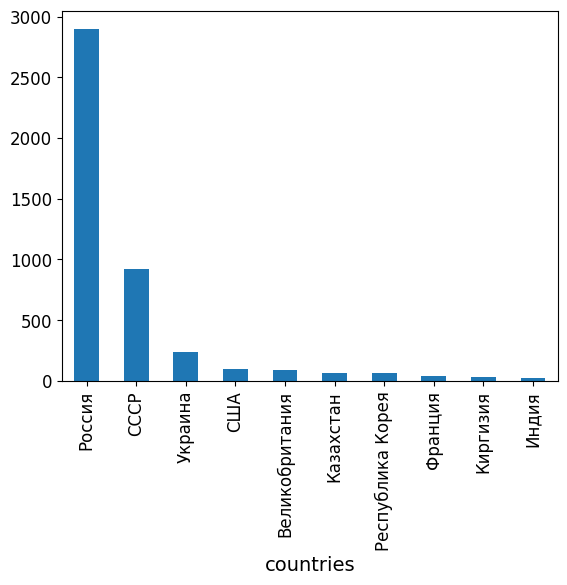

In [45]:
items_df[items_df.title_orig.isna()].countries.value_counts().head(10).plot(kind='bar')

In [46]:
items_df.duplicated(subset=['title_orig'], keep=False).sum()

np.int64(6007)

In [47]:
items_df.duplicated(subset=['title', 'title_orig'], keep=False).sum()

np.int64(380)

In [48]:
items_df['title_orig'] = items_df['title_orig'].fillna('None') 

In [49]:
items_df['title_orig'] = items_df['title_orig'].str.lower()

In [50]:
items_df.title_orig.sample(5)

14430    monster high: electrified
3081                          none
13603                         none
13483                         none
1238           the lady in the van
Name: title_orig, dtype: object

In [51]:
items_df[['title', 'title_orig']].sample(10)

,title,title_orig
7106,кальви - столица корсиканского сада. корсика,the corsican garden capital
8071,ной,none
10439,казнь после смерти,өлімнен соңғы жаза
5848,поезд в пусан (расширенная версия),train to busan (extended version)
516,к-19,k-19: the widowmaker
998,экстрасенсы,solace
15366,горбатые киты. французская полинезия,humpback whales
12769,риф. новые приключения (с тифлокомментарием),go fish (with audio description)
5463,невидимка,hollow man
4148,сыщик,syshchik


<Axes: >

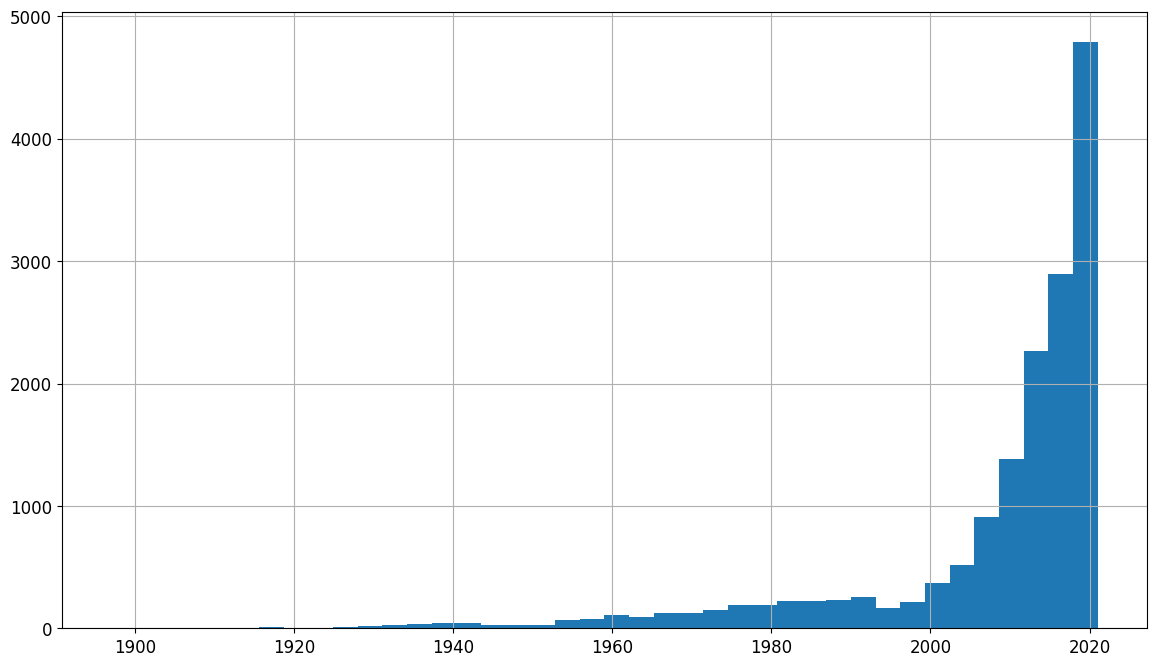

In [52]:
items_df.release_year.hist(figsize=(14, 8), bins=40)

In [53]:
items_df[items_df['release_year'].isna()].sample(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
15609,15173,1,порт - сересо осака,none,NaN,футбол,Россия,NaN,0.0,NaN,NaN,NaN,Лига чемпионов AFC - это главный клубный футбо...,"Порт, -, Сересо, Осака, Россия, спорт-фитнес, ..."
6283,10185,0,прокачка,none,NaN,"фитнес, спорт",NaN,NaN,6.0,NaN,NaN,NaN,Прокачай свое тело вместе с комплексом трениро...,Прокачка
5973,6872,0,жиросжигающий интенсив,none,NaN,фитнес,Россия,NaN,6.0,NaN,NaN,NaN,Программа от Motify интенсивных тренировок для...,"Жиросжигающий, интенсив, Россия, спорт-фитнес,..."
9653,13608,0,путь к гармонии,none,NaN,"фитнес, спорт",NaN,NaN,6.0,NaN,NaN,NaN,"Программа медитации от Motify, которая поможет...","ПУТЬ, К, ГАРМОНИИ"
13494,10276,1,джохор - пхохан стилерс,none,NaN,футбол,Россия,NaN,0.0,NaN,NaN,NaN,Лига чемпионов AFC - это главный клубный футбо...,"Джохор, -, Пхохан, Стилерс, Россия, спорт-фитн..."


In [54]:
items_df[items_df['release_year'].isna()][['genres', 'countries']].value_counts().head(10)

genres                                                 countries       
фитнес                                                 Россия              59
футбол                                                 Россия              22
зарубежные, детские песни, развитие, для детей         Республика Корея     1
зарубежные, для детей, западные мультфильмы, развитие  Республика Корея     1
фитнес                                                 Великобритания       1
Name: count, dtype: int64

In [55]:
items_df.release_year.isna().sum()

np.int64(98)

In [56]:
import re

def extract_year(keywords):
    match = re.search(r"\b(19\d{2}|20\d{2})\b", keywords)
    return match.group(0) if match else None

items_df["release_year"] = items_df.apply(
    lambda row: extract_year(row["keywords"]) if pd.isna(row["release_year"]) else row["release_year"],
    axis=1
)

In [57]:
items_df.release_year.isna().sum()

np.int64(77)

In [58]:
items_df['release_year_cat'] = 'None'
items_df['release_year'] = pd.to_numeric(items_df['release_year'], errors='coerce')

items_df.loc[(items_df['release_year'].notna()) & (items_df['release_year'] < 1920), 'release_year_cat'] = 'inf_1920'
items_df.loc[(items_df['release_year'].notna()) & (items_df['release_year'] >= 2020), 'release_year_cat'] = '2020_inf'

for i in range(1920, 2020, 10):
    mask = (items_df['release_year'].notna()) & (items_df['release_year'] >= i) & (items_df['release_year'] < i + 10)
    items_df.loc[mask, 'release_year_cat'] = f'{i}-{i+10}'

In [59]:
items_df.release_year_cat.value_counts()

release_year_cat
2010-2020    8788
2020_inf     2199
2000-2010    2168
1980-1990     745
1990-2000     636
1970-1980     553
1960-1970     342
1950-1960     199
1940-1950     117
1930-1940     104
None           77
1920-1930      24
inf_1920       11
Name: count, dtype: int64

In [60]:
items_df.sample(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_cat
13514,12774,1,дорожное приключение,road trip,2000.0,комедии,США,NaN,18.0,NaN,Тодд Филлипс,"Брекин Мейер, Шонн Уильям Скотт, Эми Смарт, Па...","Студент Джош изменил своей девушке Тиффани, ко...","сексизм, банк спермы, политика, блондинка, пое...",2000-2010
11931,14781,1,обратный билет,none,2012.0,"русские, мелодрамы",Россия,NaN,12.0,NaN,Александр Кананович,"Андрей Биланов, Дианисий Толоконников, Елена П...","Фильм рассказывает о девушке Марии, которая бы...","Обратный, билет, 2012, Россия, жизнь, преступл...",2010-2020
2568,6725,0,песни про машины,none,NaN,"зарубежные, детские песни, развитие, для детей",Республика Корея,NaN,0.0,NaN,NaN,NaN,"Сборник красочных песенок, которые рассказываю...","Песни, про, Машины, Южная, Корея, музыка, добр...",None
12960,14030,0,любви целительная сила,lyubvi tselitelnaya sila,2012.0,мелодрамы,Россия,NaN,16.0,NaN,Виктор Татарский,"Лянка Грыу, Алексей Анищенко, Ольга Рептух, Ма...",У Ани большая радость - она побеждает на конку...,NaN,2010-2020
14231,101,1,куриоса,curiosa,2019.0,"историческое, мелодрамы",Франция,NaN,18.0,NaN,Лу Жене,"Ноэми Мерлан, Нильс Шнайдер, Бенжамен Лаверн, ...","Историческая драма про любовный треугольник, к...",", 1890-е, Большой пенис, Брак без секса, Вдохн...",2010-2020


In [61]:
items_df.genres.value_counts()

genres
документальное                                                             816
драмы                                                                      719
комедии                                                                    564
для взрослых                                                               482
русские, мелодрамы                                                         416
                                                                          ... 
драмы, зарубежные, спорт, семейное, комедии                                  1
музыкальные, драмы, зарубежные, семейное, комедии                            1
приключения, полнометражные, зарубежные, семейное, западные мультфильмы      1
детективы, приключения, зарубежные, триллеры, ужасы                          1
фэнтези, семейное, криминал, комедии                                         1
Name: count, Length: 2771, dtype: int64

In [62]:
items_df.genres.isnull().sum()

np.int64(0)

In [63]:
nlp = stanza.Pipeline('ru', processors='tokenize,pos,lemma')

def lemmatize_genres_russian(genres):
    if pd.isna(genres): 
        return ''
    
    genre_list = genres.split(', ') 
    lemmatized_genres = []
    
    for genre in genre_list:
        doc = nlp(genre)
        lemmatized_genre = " ".join([word.lemma for word in doc.iter_words()])
        lemmatized_genres.append(lemmatized_genre)
    
    return ", ".join(lemmatized_genres)

2025-02-24 19:57:01 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-02-24 19:57:01 INFO: Downloaded file to /Users/maksvell/stanza_resources/resources.json
2025-02-24 19:57:02 INFO: Loading these models for language: ru (Russian):
| Processor | Package            |
----------------------------------
| tokenize  | syntagrus          |
| pos       | syntagrus_charlm   |
| lemma     | syntagrus_nocharlm |

2025-02-24 19:57:02 INFO: Using device: cpu
2025-02-24 19:57:02 INFO: Loading: tokenize
2025-02-24 19:57:02 INFO: Loading: pos
2025-02-24 19:57:03 INFO: Loading: lemma
2025-02-24 19:57:04 INFO: Done loading processors!


In [64]:
items_df['genres'] = items_df['genres'].apply(lemmatize_genres_russian)

In [65]:
items_df.genres.sample(10)

14292                                                драма
10156                    драма, мелодрама, фэнтез, комедия
15053       боевик, драма, зарубежный, триллер, фантастика
11565    детский, полнометражный, приключение, зарубежн...
1783                            мелодрама, фэнтез, комедия
304                                            мультсериал
9063                            драма, зарубежный, комедия
3069                                                 драма
716                                           для взрослый
15893                              русский, документальный
Name: genres, dtype: object

In [66]:
items_df.countries.value_counts()

countries
Россия                                                                  4237
США                                                                     4090
СССР                                                                    1401
Франция                                                                 1158
Великобритания                                                           718
                                                                        ... 
Франция, Китай                                                             1
Мальта                                                                     1
Великобритания, Ирландия, Канада, США, Индия                               1
Швеция, Германия, Норвегия, Дания, Исландия, Бельгия, Великобритания       1
Финляндия, Германия                                                        1
Name: count, Length: 687, dtype: int64

In [67]:
items_df.countries.isnull().sum()

np.int64(37)

In [68]:
items_df[items_df.countries.isna()].sample(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_cat
5662,15019,0,работа в офисе,none,NaN,"фитнес, спорт",NaN,NaN,6.0,NaN,NaN,NaN,Цель программы модифицировать привычный пассив...,"Работа, офисе",None
14830,10251,0,работа со стопой,none,NaN,"фитнес, спорт",NaN,NaN,6.0,NaN,NaN,NaN,Уникальная тренировочная программа рассчитана ...,"Работа, со, стопой",None
374,10656,0,медитации для жизни,none,NaN,фитнес,NaN,NaN,6.0,NaN,NaN,NaN,"В этой программе собраны 3 базовых урока, на к...","Медитации, для, жизни, спорт-фитнес, спорт-тре...",None
9875,14893,0,похудение и рельеф,none,2020.0,"фитнес, спорт",NaN,NaN,6.0,NaN,NaN,NaN,Комплекс вы можете выполнять 4-5 недель в дома...,"Похудение, рельеф, 2020, спорт-фитнес, спорт-т...",2020_inf
2483,15508,0,тайная комната,none,2021.0,"русский, для ребенок, сериал, приключение, раз...",NaN,NaN,0.0,NaN,Андрей Бахурин,"Виктория Слуцкая, Дмитрий Стрелков","Двое братьев, Даня и Яша, а также их сестрёнка...","Тайная, комната, 2021, магия, волшебство, семь...",2020_inf


In [69]:
items_df.loc[items_df.countries.isna(), 'countries'] = 'None'

In [70]:
items_df['countries'] = items_df['countries'].str.lower()
items_df['countries'] = items_df['countries'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))

<Axes: xlabel='countries'>

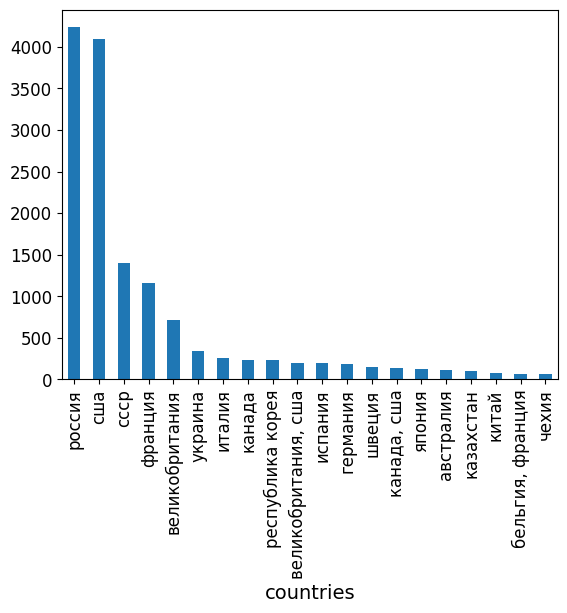

In [71]:
items_df.countries.value_counts().head(20).plot(kind='bar')

In [72]:
items_df['for_kids'].value_counts()

for_kids
0.0    452
1.0    114
Name: count, dtype: int64

In [73]:
items_df.for_kids.isnull().sum()

np.int64(15397)

In [74]:
items_df['for_kids'] = items_df['for_kids'].fillna(2)

In [75]:
items_df.for_kids.value_counts()

for_kids
2.0    15397
0.0      452
1.0      114
Name: count, dtype: int64

In [76]:
items_df.age_rating.value_counts()

age_rating
16.0    5729
12.0    4147
18.0    2547
6.0     1538
0.0     1518
21.0     482
Name: count, dtype: int64

In [77]:
items_df[items_df.age_rating.isna()]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_cat
8297,6316,0,машины-помощники,none,2016.0,"русский, для ребенок, сериал, хотеть все знать...",россия,2.0,NaN,NaN,NaN,NaN,Маленькие мальчики всего мира любят играть в м...,"Машины-помощники, 2017, Россия, работа, преодо...",2010-2020
12352,14409,0,бибабу,none,2017.0,"русский, сериал, для ребенок, хотеть все знать...",россия,2.0,NaN,NaN,NaN,NaN,В сказочное подводное царство приглашают мален...,"друзья, магия и волшебство, рыбы, моря и океан...",2010-2020


In [78]:
items_df.loc[items_df.age_rating.isna(), 'age_rating'] = 0

In [79]:
items_df.age_rating.value_counts()

age_rating
16.0    5729
12.0    4147
18.0    2547
6.0     1538
0.0     1520
21.0     482
Name: count, dtype: int64

In [80]:
items_df.studios.value_counts()

studios
HBO                         353
Ленфильм                    212
Sony Pictures               162
Ленфильм, рентв              46
Paramount                    46
Sky                          30
DAZN                         30
CBS                          27
Starz                        21
BBC                          19
Universal                    18
Showtime                     16
Warner Bros. Television      14
Cinemax                      10
Warner Bros                   9
Sony Pictures Television      7
Fox                           7
Fremantle                     4
Endemol                       4
Amediateka                    3
Sky, Fremantle                2
HBO, BBC                      2
Мосфильм                      2
Sony Plus, рентв              2
CBS All Access                2
Channel 4                     2
Sony Pictures, рентв          2
Disney                        2
HBO Max                       2
Legendary                     1
New Regency Productions       1


<Axes: xlabel='studios'>

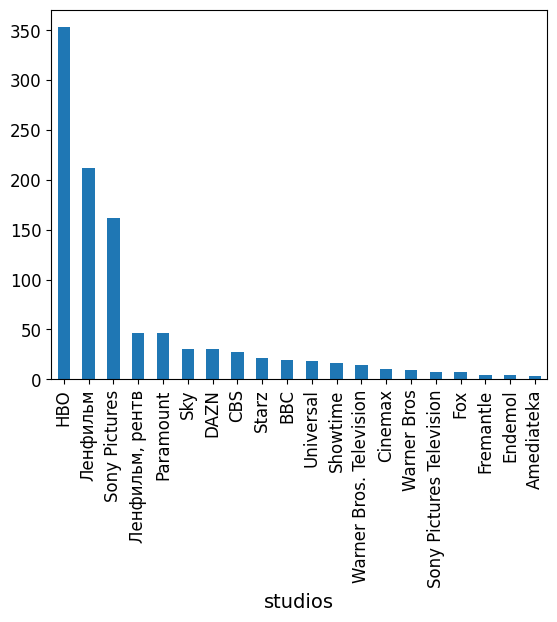

In [81]:
items_df['studios'].value_counts().head(20).plot(kind='bar')

In [82]:
items_df.studios.isnull().sum()

np.int64(14898)

In [83]:
items_df['studios'] = items_df['studios'].fillna('None')

In [84]:
items_df['studios'] = items_df['studios'].str.lower()
items_df['studios'] = items_df['studios'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))

In [85]:
items_df.directors.value_counts()

directors
Оливье Шиабоду                     511
Денис Франческо                     49
Глова Роман Юрьевич                 36
Сергей Зарев                        29
Альфред Хичкок                      28
                                  ... 
Джей Чандрашекхар                    1
Гарт Дженнингс, Кристоф Лурделе      1
Кэри Фукунага                        1
Пол Вейланд                          1
Михаил Миронов                       1
Name: count, Length: 7973, dtype: int64

In [86]:
items_df.directors.isnull().sum()

np.int64(1509)

In [87]:
items_df['directors'] = items_df['directors'].fillna('None')

In [88]:
items_df['directors'] = items_df['directors'].str.lower()

In [89]:
items_df.actors.value_counts()

actors
Александр Клюквин                                                                                                                                                              25
Тайлер Никсон, Маркус Лондон, Томми Ганн                                                                                                                                       16
Жан-Пьер Морель, Оливье Шиабоду                                                                                                                                                 8
Кэти Морган                                                                                                                                                                     6
Молли Мэнсон                                                                                                                                                                    6
                                                                                                       

In [90]:
items_df.actors.isnull().sum()

np.int64(2619)

In [91]:
items_df['actors'] = items_df['actors'].fillna('None')

In [92]:
items_df['actors'] = items_df['actors'].str.lower()

In [93]:
items_df['keywords'].head()

0    Поговори, ней, 2002, Испания, друзья, любовь, ...
1    Голые, перцы, 2014, США, друзья, свадьбы, прео...
2    Тактическая, сила, 2011, Канада, бандиты, ганг...
3    45, лет, 2015, Великобритания, брак, жизнь, лю...
4    Все, решает, мгновение, 1978, СССР, сильные, ж...
Name: keywords, dtype: object

In [94]:
items_df.keywords.isnull().sum()

np.int64(423)

In [95]:
items_df['keywords'] = items_df['keywords'].fillna('None')

In [96]:
items_df['keywords'] = items_df['keywords'].str.lower()

In [97]:
items_df.description.isnull().sum()

np.int64(2)

In [98]:
items_df.loc[items_df.description.isnull()]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_cat
2660,2112,0,fizica - караоке,none,2020.0,караоке,россия,2.0,0.0,none,none,none,NaN,none,2020_inf
4297,4879,0,султан разия,razia sultan,2015.0,"исторический, индийский кино, зарубежный",индия,2.0,12.0,none,none,"панкхури авастхи, рохит пурохит, саурабх панде...",NaN,none,2010-2020


In [99]:
items_df['description'] = items_df['description'].fillna('None')

In [100]:
items_df.duplicated(subset=['item_id'], keep=False).sum()

np.int64(0)

In [101]:
items_df.duplicated(subset=['title'], keep=False).sum()

np.int64(1300)

In [102]:
items_df[items_df.duplicated(subset=['content_type', 'countries', 'title', 'directors'], keep=False)].sort_values('title')[['content_type', 'title', 'countries', 'for_kids', 'directors']].head()

,content_type,title,countries,for_kids,directors
7333,1,пираты по соседству,нидерланды,2.0,пим ван хёве
12757,1,пираты по соседству,нидерланды,2.0,пим ван хёве


In [103]:
items_df = items_df.drop_duplicates(subset=['content_type', 'countries', 'title', 'directors'], keep='first')

In [104]:
items_df = items_df.replace(['none', 'None'], 'none')

In [105]:
items_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 15962 entries, 0 to 15962
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   item_id           15962 non-null  int64  
 1   content_type      15962 non-null  int64  
 2   title             15962 non-null  object 
 3   title_orig        15962 non-null  object 
 4   release_year      15885 non-null  float64
 5   genres            15962 non-null  object 
 6   countries         15962 non-null  object 
 7   for_kids          15962 non-null  float64
 8   age_rating        15962 non-null  float64
 9   studios           15962 non-null  object 
 10  directors         15962 non-null  object 
 11  actors            15962 non-null  object 
 12  description       15962 non-null  object 
 13  keywords          15962 non-null  object 
 14  release_year_cat  15962 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 1.9+ MB


In [106]:
items_df.sample(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_cat
13126,11150,1,ехали в трамвае ильф и петров,none,1972.0,"русский, комедия",ссср,2.0,12.0,none,виктор титов,"нина агапова, лев дуров, нина алисова, владими...","Этот фильм будет любопытен всем тем, кто интер...","ехали, трамвае, ильф, петров, 1972, ссср",1970-1980
15154,9752,1,найти и уничтожить,search and destroy,2020.0,боевик,болгария,2.0,18.0,none,дэнни лернер,"дилан брюс, джулиан костов, сергей бадюк, тим ...",Офицер разведки Джон Каттер теряет в бою весь ...,"2020, болгария, найти, уничтожить",2020_inf
7010,16463,1,после. глава 2,after we colided,2020.0,"драма, мелодрама",сша,2.0,16.0,none,роджер камбл,"джозефина лэнгфорд, хиро файнс-тиффин, дилан с...",Встреча с Хардином разделила её жизнь на до и ...,"на основе романа или книги, любовь, подростков...",2020_inf
7098,15909,1,принцесса лебедь: королевская свадьба,the swan princess: a royal wedding,2020.0,"мультфильм, фэнтез, мелодрама",сша,2.0,6.0,none,ричард рич,none,"Действие сказки переносится в загадочные, полн...",", любовь, 2020, соединенные штаты, принцесса, ...",2020_inf
5231,512,1,рядовой чээрин,none,2020.0,военный,россия,2.0,16.0,none,дмитрий кольцов,"айтал степанов, александр казанцев, даниил жур...",Глубокая осень 1943 года. Немецкие снайперы хо...,"2020, россия, рядовой, чээрин",2020_inf


ФИЧИ

In [107]:
# Фичи на основе названия и описания
items_df['title_length'] = items_df['title'].apply(lambda x: len(str(x)))
items_df['title_word_count'] = items_df['title'].apply(lambda x: len(str(x).split()))
items_df['title_unique_chars'] = items_df['title'].apply(lambda x: len(set(str(x))))

items_df['desc_word_count'] = items_df['description'].apply(lambda x: len(str(x).split()))
items_df['desc_avg_word_length'] = items_df['description'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if pd.notna(x) else 0)
items_df['desc_unique_words_ratio'] = items_df['description'].apply(lambda x: len(set(str(x).split())) / len(str(x).split()) if pd.notna(x) and len(str(x).split()) > 0 else 0)

In [108]:
# Фичи по ключевым словам
items_df['num_keywords'] = items_df['keywords'].apply(lambda x: len(str(x).split(', ')) if pd.notna(x) else 0)
items_df['keywords_unique_ratio'] = items_df['keywords'].apply(lambda x: len(set(str(x).split(', '))) / len(str(x).split(', ')) if pd.notna(x) and len(str(x).split(', ')) > 0 else 0)

In [109]:
# Фичи по жанрам
items_df['num_genres'] = items_df['genres'].apply(lambda x: len(str(x).split(', ')) if pd.notna(x) else 0)

In [110]:
# Фичи по странам
items_df['num_countries'] = items_df['countries'].apply(lambda x: len(str(x).split(', ')) if pd.notna(x) else 0)
items_df['is_international'] = (items_df['num_countries'] > 1).astype(int)

In [111]:
# Фичи по студиям
items_df['num_studios'] = items_df['studios'].apply(lambda x: len(str(x).split(', ')) if pd.notna(x) else 0)

# Фичи по режиссерам
items_df['num_directors'] = items_df['directors'].apply(lambda x: len(str(x).split(', ')) if pd.notna(x) else 0)

# Фичи по актерам
items_df['num_actors'] = items_df['actors'].apply(lambda x: len(str(x).split(', ')) if pd.notna(x) else 0)

In [112]:
# Фичи по году выпуска
items_df['release_decade'] = (items_df['release_year'] // 10) * 10
items_df['is_classic'] = (items_df['release_year'] < 1990).astype(int)
items_df['is_recent'] = (items_df['release_year'] >= 2015).astype(int)

# Бинарные флаги
items_df['is_kids_content'] = (items_df['for_kids'] == 1).astype(int)
items_df['is_series'] = (items_df['content_type'] == 'series').astype(int)
items_df['is_adult_content'] = (items_df['age_rating'] == 18).astype(int)

In [113]:
# Тематическое разнообразие
items_df['genre_diversity'] = items_df['genres'].apply(lambda x: len(set(x.split(', '))))
items_df['country_diversity'] = items_df['countries'].apply(lambda x: len(set(x.split(', '))))

# Временные характеристики
items_df['release_month'] = pd.to_datetime(items_df['release_year'], format='%Y').dt.month
items_df['release_day_of_week'] = pd.to_datetime(items_df['release_year'], format='%Y').dt.dayofweek

In [114]:
# Уникальность ключевых слов
items_df['keyword_diversity'] = items_df['keywords'].apply(lambda x: len(set(x.split(', '))) if pd.notna(x) else 0)

# Уникальность студий
items_df['studio_diversity'] = items_df['studios'].apply(lambda x: len(set(x.split(', '))) if pd.notna(x) else 0)

In [115]:
# Год выпуска в логарифмическом масштабе 
items_df['log_release_year'] = np.log1p(items_df['release_year'])

# Категория по возрасту релиза
current_year = 2025  # Подставляем текущий год
items_df['years_since_release'] = current_year - items_df['release_year']
items_df['release_age_group'] = pd.cut(
    items_df['years_since_release'],
    bins=[0, 1, 5, 10, 20, 50, 100, np.inf],
    labels=['new', 'very_recent', 'recent', 'semi_old', 'old', 'classic', 'ancient']
)

In [116]:
popular_keywords = ['боевик', 'комедия', 'драма', 'детектив', 'фантастика', 'ужасы', 'триллер']
popular_keywords = set(map(str.lower, popular_keywords))  

def count_popular_keywords(keyword_str):
    if pd.isna(keyword_str) or keyword_str == 'None':
        return 0, 0 

    keyword_list = set(map(str.strip, keyword_str.lower().split(', ')))  

    intersection = keyword_list & popular_keywords  

    return len(intersection) > 0, len(intersection)

items_df[['has_popular_genres', 'num_popular_genres']] = items_df['genres'].apply(
    lambda x: pd.Series(count_popular_keywords(x))
)

In [117]:
# Время с момента релиза в месяцах
items_df['months_since_release'] = (current_year - items_df['release_year']) * 12 + pd.to_datetime(items_df['release_year'], format='%Y').dt.month

# Средняя длина описания
items_df['avg_desc_word_length'] = items_df['description'].apply(lambda x: np.mean([len(word) for word in str(x).split()]) if pd.notna(x) else 0)

# Процент уникальных слов в описании
items_df['desc_unique_percentage'] = items_df['description'].apply(
    lambda x: len(set(str(x).split())) / len(str(x).split()) if pd.notna(x) and len(str(x).split()) > 0 else 0
)

# Количество уникальных жанров
items_df['unique_genre_count'] = items_df['genres'].apply(lambda x: len(set(str(x).split(', '))) if pd.notna(x) else 0)

# Статистика по ключевым словам: минимальное и максимальное количество слов в ключевых словах
items_df['min_keywords_length'] = items_df['keywords'].apply(lambda x: min([len(word) for word in str(x).split(', ')]) if pd.notna(x) and len(str(x).split(', ')) > 0 else 0)
items_df['max_keywords_length'] = items_df['keywords'].apply(lambda x: max([len(word) for word in str(x).split(', ')]) if pd.notna(x) and len(str(x).split(', ')) > 0 else 0)

# Соотношение уникальных актёров к общему числу актёров
items_df['unique_actors_ratio'] = items_df['actors'].apply(
    lambda x: len(set(str(x).split(', '))) / len(str(x).split(', ')) if pd.notna(x) and len(str(x).split(', ')) > 0 else 0
)

# Соотношение уникальных режиссёров к общему числу режиссёров
items_df['unique_directors_ratio'] = items_df['directors'].apply(
    lambda x: len(set(str(x).split(', '))) / len(str(x).split(', ')) if pd.notna(x) and len(str(x).split(', ')) > 0 else 0
)

# Расстояние от среднего года выпуска (для измерения старости контента)
avg_release_year = items_df['release_year'].mean()
items_df['release_year_distance'] = np.abs(items_df['release_year'] - avg_release_year)

# Количество лет с момента выпуска в логарифмическом масштабе
items_df['log_years_since_release'] = np.log1p(items_df['years_since_release'])

# Количество стран, где доступен контент
items_df['unique_countries_count'] = items_df['countries'].apply(lambda x: len(set(str(x).split(', '))) if pd.notna(x) else 0)

# Взаимосвязь жанров и стран: сколько уникальных стран для каждого жанра
items_df['genre_country_interaction'] = items_df.apply(
    lambda row: len(set(str(row['genres']).split(', ')) & set(str(row['countries']).split(', '))) if pd.notna(row['genres']) and pd.notna(row['countries']) else 0,
    axis=1
)

# Сумма количества жанров, стран и студий для определения контентного объема
items_df['total_content_volume'] = items_df['num_genres'] + items_df['num_countries'] + items_df['num_studios']

# Количество лет с момента релиза контента в зависимости от разных категорий возраста
items_df['age_rating_class'] = items_df['age_rating'].apply(
    lambda x: 'kids' if x <= 12 else ('teen' if x <= 17 else 'adult') if pd.notna(x) else 'unknown'
)

# Количество уникальных жанров с учетом "нетипичных" жанров
items_df['non_standard_genres_count'] = items_df['genres'].apply(
    lambda x: len([genre for genre in str(x).split(', ') if genre not in popular_keywords]) if pd.notna(x) else 0
)

In [118]:
items_df.sample(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,...,max_keywords_length,unique_actors_ratio,unique_directors_ratio,release_year_distance,log_years_since_release,unique_countries_count,genre_country_interaction,total_content_volume,age_rating_class,non_standard_genres_count
3221,6228,1,гадкие лебеди (жестовым языком),none,2006.0,"фантастика, драма, детектив","россия, франция",2.0,16.0,none,...,9,1.0,1.0,1.948505,2.995732,2,0,6,teen,0
10787,14113,1,доктор дулиттл,doctor dolittle,1998.0,"семейный, фэнтез, комедия",сша,2.0,12.0,none,...,19,1.0,1.0,9.948505,3.332205,1,0,5,kids,2
9097,2789,0,без комплексов,skin to the max,2011.0,документальный,сша,2.0,18.0,hbo,...,10,1.0,1.0,3.051495,2.708050,1,0,3,adult,1
12202,15407,0,правила охоты. отступник,none,2014.0,"боевик, русский",россия,2.0,16.0,none,...,14,1.0,1.0,6.051495,2.484907,1,0,4,teen,1
13171,16255,0,дикий округ,none,2018.0,"боевик, драма, зарубежный, криминал",колумбия,2.0,16.0,none,...,12,1.0,1.0,10.051495,2.079442,1,0,6,teen,2


In [119]:
duplicates = {col: items_df[col].duplicated().sum() for col in items_df.columns}

duplicates

{'item_id': np.int64(0),
 'content_type': np.int64(15960),
 'title': np.int64(686),
 'title_orig': np.int64(5418),
 'release_year': np.int64(15856),
 'genres': np.int64(13206),
 'countries': np.int64(15404),
 'for_kids': np.int64(15959),
 'age_rating': np.int64(15956),
 'studios': np.int64(15923),
 'directors': np.int64(7992),
 'actors': np.int64(2966),
 'description': np.int64(343),
 'keywords': np.int64(470),
 'release_year_cat': np.int64(15949),
 'title_length': np.int64(15875),
 'title_word_count': np.int64(15947),
 'title_unique_chars': np.int64(15929),
 'desc_word_count': np.int64(15714),
 'desc_avg_word_length': np.int64(8974),
 'desc_unique_words_ratio': np.int64(14203),
 'num_keywords': np.int64(15827),
 'keywords_unique_ratio': np.int64(15408),
 'num_genres': np.int64(15953),
 'num_countries': np.int64(15953),
 'is_international': np.int64(15960),
 'num_studios': np.int64(15960),
 'num_directors': np.int64(15947),
 'num_actors': np.int64(15889),
 'release_decade': np.int64(15

In [120]:
items_df.columns

Index(['item_id', 'content_type', 'title', 'title_orig', 'release_year',
       'genres', 'countries', 'for_kids', 'age_rating', 'studios', 'directors',
       'actors', 'description', 'keywords', 'release_year_cat', 'title_length',
       'title_word_count', 'title_unique_chars', 'desc_word_count',
       'desc_avg_word_length', 'desc_unique_words_ratio', 'num_keywords',
       'keywords_unique_ratio', 'num_genres', 'num_countries',
       'is_international', 'num_studios', 'num_directors', 'num_actors',
       'release_decade', 'is_classic', 'is_recent', 'is_kids_content',
       'is_series', 'is_adult_content', 'genre_diversity', 'country_diversity',
       'release_month', 'release_day_of_week', 'keyword_diversity',
       'studio_diversity', 'log_release_year', 'years_since_release',
       'release_age_group', 'has_popular_genres', 'num_popular_genres',
       'months_since_release', 'avg_desc_word_length',
       'desc_unique_percentage', 'unique_genre_count', 'min_keywords_leng

## Interactions

In [121]:
interactions_df = pd.read_csv('interactions.csv', parse_dates=['last_watch_dt'])

In [122]:
interactions_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [123]:
interactions_df.shape

(5476251, 5)

In [124]:
interactions_df.nunique()

user_id          962179
item_id           15706
last_watch_dt       163
total_dur        129788
watched_pct         101
dtype: int64

In [125]:
print(f'Data date range: {interactions_df.last_watch_dt.min().date()} - {interactions_df.last_watch_dt.max().date()}')

Data date range: 2021-03-13 - 2021-08-22


In [126]:
interactions_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   user_id        5476251 non-null  int64         
 1   item_id        5476251 non-null  int64         
 2   last_watch_dt  5476251 non-null  datetime64[ns]
 3   total_dur      5476251 non-null  int64         
 4   watched_pct    5475423 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


In [127]:
interactions_df.watched_pct.max()

np.float64(100.0)

In [128]:
interactions_df.watched_pct.min()

np.float64(0.0)

In [129]:
interactions_df['watched_pct'] = interactions_df['watched_pct'].astype(pd.Int8Dtype())

In [130]:
interactions_df['watched_pct'] = interactions_df['watched_pct'].fillna(0)

<Axes: >

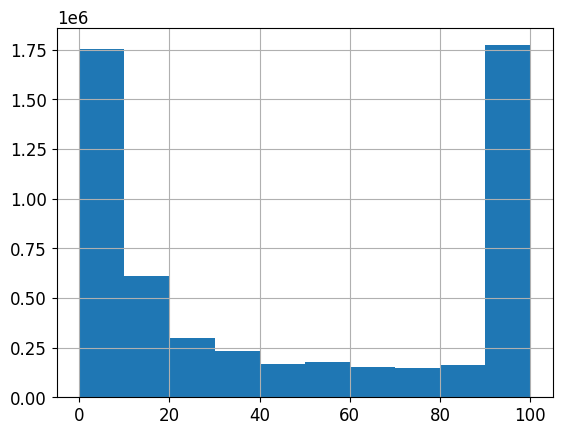

In [131]:
interactions_df['watched_pct'].hist()

<Axes: >

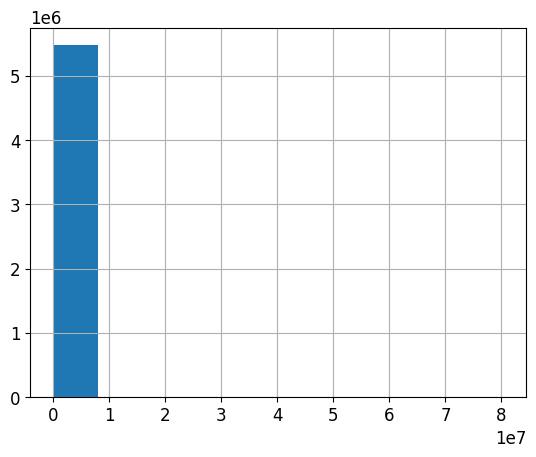

In [132]:
interactions_df['total_dur'].hist()

In [133]:
interactions_df[interactions_df['total_dur'] > 200000].shape

(16042, 5)

<Axes: >

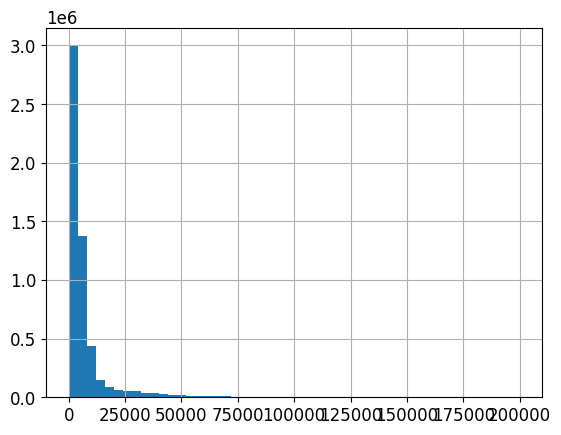

In [134]:
interactions_df[interactions_df['total_dur'] < 200000].total_dur.hist(bins=50)

In [135]:
interactions_df['last_watch_dt'] = pd.to_datetime(interactions_df['last_watch_dt'])

In [136]:
interactions_df['last_watch_dt'].min()

Timestamp('2021-03-13 00:00:00')

In [137]:
interactions_df['last_watch_dt'].max()

Timestamp('2021-08-22 00:00:00')

<Axes: >

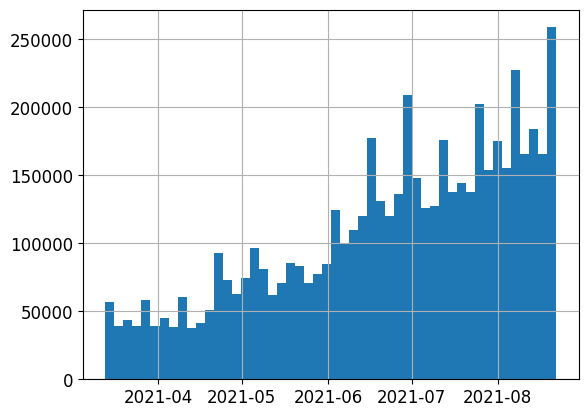

In [138]:
interactions_df['last_watch_dt'].hist(bins=50)

In [139]:
interactions_df.duplicated(subset=['user_id', 'item_id'], keep=False).sum()

np.int64(0)

In [140]:
interactions_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   user_id        5476251 non-null  int64         
 1   item_id        5476251 non-null  int64         
 2   last_watch_dt  5476251 non-null  datetime64[ns]
 3   total_dur      5476251 non-null  int64         
 4   watched_pct    5476251 non-null  Int8          
dtypes: Int8(1), datetime64[ns](1), int64(3)
memory usage: 177.6 MB


In [141]:
interactions_df.columns

Index(['user_id', 'item_id', 'last_watch_dt', 'total_dur', 'watched_pct'], dtype='object')

# ФИЧИ

## USERS

In [142]:
# Активность пользователя
users_df['total_watch_time'] = interactions_df.groupby('user_id')['total_dur'].sum().reset_index(name='total_watch_time')['total_watch_time']
users_df['average_session_duration'] = interactions_df.groupby('user_id')['total_dur'].mean().reset_index(name='average_session_duration')['average_session_duration']

# Предпочтения пользователя
users_df['favorite_genres'] = interactions_df.merge(items_df[['item_id', 'genres']], on='item_id').groupby('user_id')['genres'].apply(lambda x: ', '.join(x)).reset_index(name='favorite_genres')['favorite_genres']
users_df['favorite_countries'] = interactions_df.merge(items_df[['item_id', 'countries']], on='item_id').groupby('user_id')['countries'].apply(lambda x: ', '.join(x)).reset_index(name='favorite_countries')['favorite_countries']

# Временные предпочтения
users_df['preferred_watch_time'] = interactions_df.groupby('user_id')['last_watch_dt'].apply(lambda x: x.dt.hour.mode()[0]).reset_index(name='preferred_watch_time')['preferred_watch_time']
users_df['preferred_days'] = interactions_df.groupby('user_id')['last_watch_dt'].apply(lambda x: x.dt.dayofweek.mode()[0]).reset_index(name='preferred_days')['preferred_days']

In [143]:
# Разнообразие контента
users_df['genre_diversity'] = interactions_df.merge(items_df[['item_id', 'genres']], on='item_id').groupby('user_id')['genres'].apply(lambda x: len(set(x.sum()))).reset_index(name='genre_diversity')['genre_diversity']
users_df['country_diversity'] = interactions_df.merge(items_df[['item_id', 'countries']], on='item_id').groupby('user_id')['countries'].apply(lambda x: len(set(x.sum()))).reset_index(name='country_diversity')['country_diversity']

# Социальные характеристики
users_df['number_of_unique_items_watched'] = interactions_df.groupby('user_id')['item_id'].nunique().reset_index(name='number_of_unique_items_watched')['number_of_unique_items_watched']

# Поведенческие характеристики
users_df['average_time_per_genre'] = interactions_df.merge(items_df[['item_id', 'genres']], on='item_id').groupby(['user_id', 'genres'])['total_dur'].mean().reset_index(name='average_time_per_genre')['average_time_per_genre']
users_df['watch_frequency'] = interactions_df.groupby('user_id')['last_watch_dt'].apply(lambda x: len(x.dt.to_period('W').unique())).reset_index(name='watch_frequency')['watch_frequency']

# Тренды и сезонность
users_df['trending_score'] = interactions_df.groupby('user_id').apply(lambda x: x['total_dur'].rolling(window=7, min_periods=1).mean().iloc[-1]).reset_index(name='trending_score')['trending_score']
users_df['seasonal_preference'] = interactions_df.groupby(['user_id', interactions_df['last_watch_dt'].dt.month])['total_dur'].sum().reset_index(name='seasonal_preference')['seasonal_preference']

/var/folders/pq/7p0c971j5k7dd6zbzt4kxsj40000gn/T/ipykernel_4943/1845031085.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  users_df['trending_score'] = interactions_df.groupby('user_id').apply(lambda x: x['total_dur'].rolling(window=7, min_periods=1).mean().iloc[-1]).reset_index(name='trending_score')['trending_score']


In [144]:
# Поведенческие характеристики
users_df['average_completion_rate'] = interactions_df.groupby('user_id')['watched_pct'].mean().reset_index(name='average_completion_rate')['average_completion_rate']
users_df['binge_watching_score'] = interactions_df.groupby('user_id').apply(lambda x: (x['last_watch_dt'].diff().dt.total_seconds() < 3600).sum()).reset_index(name='binge_watching_score')['binge_watching_score']

# Временные предпочтения
users_df['weekend_watch_frequency'] = interactions_df[interactions_df['last_watch_dt'].dt.weekday >= 5].groupby('user_id').size().reset_index(name='weekend_watch_frequency')['weekend_watch_frequency']
users_df['weekday_watch_frequency'] = interactions_df[interactions_df['last_watch_dt'].dt.weekday < 5].groupby('user_id').size().reset_index(name='weekday_watch_frequency')['weekday_watch_frequency']

# Предпочтения по контенту
users_df['preferred_duration'] = interactions_df.groupby('user_id')['total_dur'].median().reset_index(name='preferred_duration')['preferred_duration']
users_df['preferred_age_rating'] = interactions_df.merge(items_df[['item_id', 'age_rating']], on='item_id').groupby('user_id')['age_rating'].apply(lambda x: x.mode()[0]).reset_index(name='preferred_age_rating')['preferred_age_rating']

/var/folders/pq/7p0c971j5k7dd6zbzt4kxsj40000gn/T/ipykernel_4943/635694279.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  users_df['binge_watching_score'] = interactions_df.groupby('user_id').apply(lambda x: (x['last_watch_dt'].diff().dt.total_seconds() < 3600).sum()).reset_index(name='binge_watching_score')['binge_watching_score']


In [145]:
# Поведенческие характеристики
users_df['average_time_between_sessions'] = interactions_df.groupby('user_id')['last_watch_dt'].apply(lambda x: x.diff().dt.total_seconds().mean()).reset_index(name='average_time_between_sessions')['average_time_between_sessions']
users_df['max_session_duration'] = interactions_df.groupby('user_id')['total_dur'].max().reset_index(name='max_session_duration')['max_session_duration']

# Предпочтения по контенту
users_df['preferred_studios'] = interactions_df.merge(items_df[['item_id', 'studios']], on='item_id').groupby('user_id')['studios'].apply(lambda x: ', '.join(x)).reset_index(name='preferred_studios')['preferred_studios']
users_df['preferred_directors'] = interactions_df.merge(items_df[['item_id', 'directors']], on='item_id').groupby('user_id')['directors'].apply(lambda x: ', '.join(x)).reset_index(name='preferred_directors')['preferred_directors']
users_df['preferred_actors'] = interactions_df.merge(items_df[['item_id', 'actors']], on='item_id').groupby('user_id')['actors'].apply(lambda x: ', '.join(x)).reset_index(name='preferred_actors')['preferred_actors']

# Разнообразие контента
users_df['genre_exploration_score'] = interactions_df.merge(items_df[['item_id', 'genres']], on='item_id').groupby('user_id')['genres'].apply(lambda x: len(set(x.sum()))).reset_index(name='genre_exploration_score')['genre_exploration_score']
users_df['country_exploration_score'] = interactions_df.merge(items_df[['item_id', 'countries']], on='item_id').groupby('user_id')['countries'].apply(lambda x: len(set(x.sum()))).reset_index(name='country_exploration_score')['country_exploration_score']

In [146]:
# Поведенческие характеристики
users_df['recent_activity_score'] = interactions_df[interactions_df['last_watch_dt'] > (interactions_df['last_watch_dt'].max() - pd.Timedelta(days=30))].groupby('user_id').size().reset_index(name='recent_activity_score')['recent_activity_score']
users_df['churn_risk_score'] = interactions_df.groupby('user_id')['last_watch_dt'].apply(lambda x: (pd.Timestamp.now() - x.max()).days).reset_index(name='churn_risk_score')['churn_risk_score']

# Предпочтения по контенту
users_df['preferred_keywords'] = interactions_df.merge(items_df[['item_id', 'keywords']], on='item_id').groupby('user_id')['keywords'].apply(lambda x: ', '.join(x)).reset_index(name='preferred_keywords')['preferred_keywords']
users_df['preferred_description_length'] = interactions_df.merge(items_df[['item_id', 'desc_word_count']], on='item_id').groupby('user_id')['desc_word_count'].mean().reset_index(name='preferred_description_length')['preferred_description_length']

# Разнообразие контента
users_df['director_exploration_score'] = interactions_df.merge(items_df[['item_id', 'directors']], on='item_id').groupby('user_id')['directors'].apply(lambda x: len(set(x.sum()))).reset_index(name='director_exploration_score')['director_exploration_score']
users_df['actor_exploration_score'] = interactions_df.merge(items_df[['item_id', 'actors']], on='item_id').groupby('user_id')['actors'].apply(lambda x: len(set(x.sum()))).reset_index(name='actor_exploration_score')['actor_exploration_score']

In [147]:
users_df.sample(5)

,user_id,age,income,sex,kids_flg,total_watch_time,average_session_duration,favorite_genres,favorite_countries,preferred_watch_time,...,preferred_directors,preferred_actors,genre_exploration_score,country_exploration_score,recent_activity_score,churn_risk_score,preferred_keywords,preferred_description_length,director_exploration_score,actor_exploration_score
238120,1073032,2.0,3.0,0,False,23380,4676.000000,"драма, триллер",россия,0,...,илья куликов,"александр hовиков, валентина ляпина, никита па...",10,5,1.0,1325,"подслушано, подслушано в контакте, социальная ...",87.0,9,23
677663,659841,5.0,2.0,1,False,1363,1363.000000,"триллер, детектив",россия,0,...,душан глигоров,"антон васильев, николай шрайбер, екатерина оль...",10,5,NaN,1409,"хруст, хрусталь, хруста, хрус, полицейский, пе...",59.0,12,25
453591,95020,2.0,2.0,0,False,54729,3909.214286,"боевик, триллер","великобритания, сша",0,...,гай ричи,"джейсон стэйтем, холт маккэллани, джеффри доно...",11,16,NaN,1302,"ограбление, криминальный авторитет, месть, пер...",84.0,7,26
285976,950594,2.0,3.0,1,True,84257,8425.700000,драма,"сша, франция",0,...,джеймс мэнголд,"кристиан бэйл, мэтт дэймон, катрина балф, трэй...",4,11,3.0,1287,"по мотивам романа или книги, биография, спорт,...",67.0,12,22
668638,945337,2.0,3.0,1,False,5251,5251.000000,"драма, боевик, триллер","сша, франция, великобритания, сша",0,...,"джеймс мэнголд, гай ричи","кристиан бэйл, мэтт дэймон, катрина балф, трэй...",14,18,NaN,1392,"по мотивам романа или книги, биография, спорт,...",75.5,16,26


In [148]:
users_df.columns

Index(['user_id', 'age', 'income', 'sex', 'kids_flg', 'total_watch_time',
       'average_session_duration', 'favorite_genres', 'favorite_countries',
       'preferred_watch_time', 'preferred_days', 'genre_diversity',
       'country_diversity', 'number_of_unique_items_watched',
       'average_time_per_genre', 'watch_frequency', 'trending_score',
       'seasonal_preference', 'average_completion_rate',
       'binge_watching_score', 'weekend_watch_frequency',
       'weekday_watch_frequency', 'preferred_duration', 'preferred_age_rating',
       'average_time_between_sessions', 'max_session_duration',
       'preferred_studios', 'preferred_directors', 'preferred_actors',
       'genre_exploration_score', 'country_exploration_score',
       'recent_activity_score', 'churn_risk_score', 'preferred_keywords',
       'preferred_description_length', 'director_exploration_score',
       'actor_exploration_score'],
      dtype='object')

## ITEMS

In [149]:
# Популярность контента
items_df['view_count'] = interactions_df.groupby('item_id').size().reset_index(name='view_count')['view_count']
items_df['average_watch_duration'] = interactions_df.groupby('item_id')['total_dur'].mean().reset_index(name='average_watch_duration')['average_watch_duration']

# Тренды
items_df['trending_score'] = interactions_df.groupby('item_id').apply(lambda x: x['total_dur'].rolling(window=7, min_periods=1).mean().iloc[-1]).reset_index(name='trending_score')['trending_score']

# Сезонность
items_df['seasonal_popularity'] = interactions_df.groupby(['item_id', interactions_df['last_watch_dt'].dt.month])['total_dur'].sum().reset_index(name='seasonal_popularity')['seasonal_popularity']

# Тематическое разнообразие
items_df['genre_diversity'] = items_df['genres'].apply(lambda x: len(set(x.split(', '))))
items_df['country_diversity'] = items_df['countries'].apply(lambda x: len(set(x.split(', '))))

# Временные характеристики
items_df['release_month'] = pd.to_datetime(items_df['release_year'], format='%Y').dt.month
items_df['release_day_of_week'] = pd.to_datetime(items_df['release_year'], format='%Y').dt.dayofweek

# Технические характеристики
items_df['duration'] = interactions_df.groupby('item_id')['total_dur'].sum().reset_index(name='duration')['duration']

/var/folders/pq/7p0c971j5k7dd6zbzt4kxsj40000gn/T/ipykernel_4943/374089686.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  items_df['trending_score'] = interactions_df.groupby('item_id').apply(lambda x: x['total_dur'].rolling(window=7, min_periods=1).mean().iloc[-1]).reset_index(name='trending_score')['trending_score']


In [150]:
# Популярность контента
items_df['recent_popularity'] = interactions_df[interactions_df['last_watch_dt'] > (interactions_df['last_watch_dt'].max() - pd.Timedelta(days=30))].groupby('item_id').size().reset_index(name='recent_popularity')['recent_popularity']
items_df['peak_view_period'] = interactions_df.groupby('item_id')['last_watch_dt'].apply(lambda x: x.dt.to_period('M').value_counts().idxmax()).reset_index(name='peak_view_period')['peak_view_period']

# Рейтинги и отзывы
items_df['rating_trend'] = interactions_df.groupby('item_id').apply(lambda x: x['watched_pct'].expanding().mean().iloc[-1]).reset_index(name='rating_trend')['rating_trend']
items_df['positive_review_ratio'] = interactions_df.groupby('item_id').apply(lambda x: (x['watched_pct'] > 30).mean()).reset_index(name='positive_review_ratio')['positive_review_ratio']

# Тренды
items_df['trending_velocity'] = interactions_df.groupby('item_id').apply(lambda x: x['total_dur'].diff().rolling(window=7).mean().iloc[-1]).reset_index(name='trending_velocity')['trending_velocity']
items_df['seasonal_trend'] = interactions_df.groupby(['item_id', interactions_df['last_watch_dt'].dt.quarter])['total_dur'].sum().reset_index(name='seasonal_trend')['seasonal_trend']

/var/folders/pq/7p0c971j5k7dd6zbzt4kxsj40000gn/T/ipykernel_4943/749342844.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  items_df['rating_trend'] = interactions_df.groupby('item_id').apply(lambda x: x['watched_pct'].expanding().mean().iloc[-1]).reset_index(name='rating_trend')['rating_trend']
/var/folders/pq/7p0c971j5k7dd6zbzt4kxsj40000gn/T/ipykernel_4943/749342844.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence t

In [151]:
# Популярность контента
items_df['view_count_last_month'] = interactions_df[interactions_df['last_watch_dt'] > (interactions_df['last_watch_dt'].max() - pd.Timedelta(days=30))].groupby('item_id').size().reset_index(name='view_count_last_month')['view_count_last_month']
items_df['view_count_last_week'] = interactions_df[interactions_df['last_watch_dt'] > (interactions_df['last_watch_dt'].max() - pd.Timedelta(days=7))].groupby('item_id').size().reset_index(name='view_count_last_week')['view_count_last_week']

# Рейтинги и отзывы
items_df['average_rating_last_month'] = interactions_df[interactions_df['last_watch_dt'] > (interactions_df['last_watch_dt'].max() - pd.Timedelta(days=30))].groupby('item_id')['watched_pct'].mean().reset_index(name='average_rating_last_month')['average_rating_last_month']

# Тренды
items_df['trending_acceleration'] = interactions_df.groupby('item_id').apply(lambda x: x['total_dur'].diff().diff().rolling(window=7).mean().iloc[-1]).reset_index(name='trending_acceleration')['trending_acceleration']
items_df['seasonal_trend_change'] = interactions_df.groupby(['item_id', interactions_df['last_watch_dt'].dt.quarter])['total_dur'].sum().pct_change().reset_index(name='seasonal_trend_change')['seasonal_trend_change']

# Временные характеристики
items_df['release_quarter'] = pd.to_datetime(items_df['release_year'], format='%Y').dt.quarter
items_df['time_of_day_popularity'] = interactions_df.groupby(['item_id', interactions_df['last_watch_dt'].dt.hour // 6])['total_dur'].sum().reset_index(name='time_of_day_popularity')['time_of_day_popularity']


/var/folders/pq/7p0c971j5k7dd6zbzt4kxsj40000gn/T/ipykernel_4943/2237429661.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  items_df['trending_acceleration'] = interactions_df.groupby('item_id').apply(lambda x: x['total_dur'].diff().diff().rolling(window=7).mean().iloc[-1]).reset_index(name='trending_acceleration')['trending_acceleration']


In [152]:
items_df.sample(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,...,positive_review_ratio,trending_velocity,seasonal_trend,view_count_last_month,view_count_last_week,average_rating_last_month,trending_acceleration,seasonal_trend_change,release_quarter,time_of_day_popularity
5829,1525,1,принципиальный и жалостливый взгляд,none,1996.0,"русский, мелодрама",россия,2.0,16.0,ленфильм,...,0.503443,-562.857143,62228,238.0,15.0,40.12605,-732.857143,-0.493999,1.0,5530058.0
3331,4143,1,"дед, привет!","happier times, grump",2018.0,"драма, комедия",финляндия,2.0,16.0,none,...,0.689922,623.857143,246201,1.0,3.0,0.0,624.857143,6.524710,1.0,865675.0
3534,609,0,институт благородных девиц,none,2009.0,"исторический, русский, романтика, мелодрама",россия,2.0,16.0,none,...,0.529412,-450.428571,532,1.0,1.0,38.0,-639.428571,-0.346437,1.0,54933.0
7395,3982,1,параллельные миры,parallelnye miry,2013.0,"мелодрама, комедия",россия,2.0,16.0,none,...,1.000000,NaN,11520,11.0,NaN,39.636364,NaN,8.396411,1.0,7504.0
14359,2381,1,рыцари королевства крутизны (жестовым языком),knights of badassdom (sign language),2012.0,"ужас, зарубежный, фэнтез, комедия",сша,2.0,18.0,none,...,0.500000,824.571429,35179,NaN,NaN,<NA>,NaN,1.342924,1.0,25554.0


In [153]:
items_df.columns

Index(['item_id', 'content_type', 'title', 'title_orig', 'release_year',
       'genres', 'countries', 'for_kids', 'age_rating', 'studios', 'directors',
       'actors', 'description', 'keywords', 'release_year_cat', 'title_length',
       'title_word_count', 'title_unique_chars', 'desc_word_count',
       'desc_avg_word_length', 'desc_unique_words_ratio', 'num_keywords',
       'keywords_unique_ratio', 'num_genres', 'num_countries',
       'is_international', 'num_studios', 'num_directors', 'num_actors',
       'release_decade', 'is_classic', 'is_recent', 'is_kids_content',
       'is_series', 'is_adult_content', 'genre_diversity', 'country_diversity',
       'release_month', 'release_day_of_week', 'keyword_diversity',
       'studio_diversity', 'log_release_year', 'years_since_release',
       'release_age_group', 'has_popular_genres', 'num_popular_genres',
       'months_since_release', 'avg_desc_word_length',
       'desc_unique_percentage', 'unique_genre_count', 'min_keywords_leng

# Some stats

In [154]:
interaction_users = interactions_df['user_id'].unique()

common_users = len(np.intersect1d(interaction_users, users_df['user_id']))
users_only_in_interaction = len(np.setdiff1d(interaction_users, users_df['user_id']))
users_only_features = len(np.setdiff1d(users_df['user_id'], interaction_users))
total_users = common_users + users_only_in_interaction + users_only_features

print(f'Кол-во пользователей всего - {total_users}')
print(f'Кол-во пользователей c взаимодействиями и фичами - {common_users} ({common_users / total_users:.2%})')
print(f'Кол-во пользователей только c взаимодействиями - {users_only_in_interaction} ({users_only_in_interaction / total_users:.2%})')
print(f'Кол-во пользователей только c фичами - {users_only_features} ({users_only_features / total_users:.2%})')

Кол-во пользователей всего - 1058088
Кол-во пользователей c взаимодействиями и фичами - 744288 (70.34%)
Кол-во пользователей только c взаимодействиями - 217891 (20.59%)
Кол-во пользователей только c фичами - 95909 (9.06%)


In [155]:
interaction_items = interactions_df['item_id'].unique()

common_items = len(np.intersect1d(interaction_items, items_df['item_id']))
items_only_in_interaction = len(np.setdiff1d(interaction_items, items_df['item_id']))
items_only_features = len(np.setdiff1d(items_df['item_id'], interaction_items))
total_items = common_items + items_only_in_interaction + items_only_features
print(f'Кол-во объектов всего - {total_items}')
print(f'Кол-во объектов c взаимодействиями и фичами - {common_items} ({common_items / total_items:.2%})')
print(f'Кол-во объектов только c взаимодействиями - {items_only_in_interaction} ({items_only_in_interaction / total_items:.2%})')
print(f'Кол-во объектов только c фичами - {items_only_features} ({items_only_features / total_items:.2%})')

Кол-во объектов всего - 15963
Кол-во объектов c взаимодействиями и фичами - 15705 (98.38%)
Кол-во объектов только c взаимодействиями - 1 (0.01%)
Кол-во объектов только c фичами - 257 (1.61%)


График количества пользователей от даты

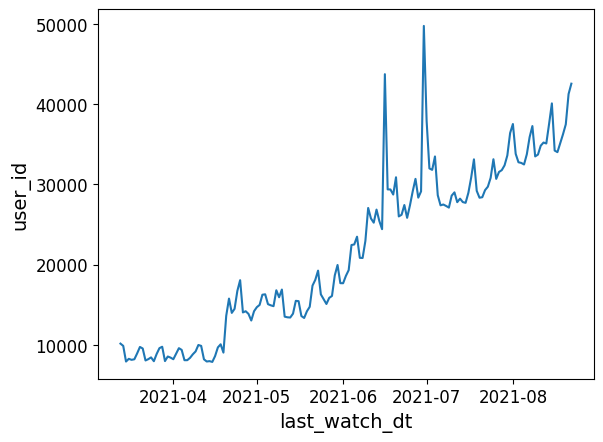

In [156]:
interactions_df_users_count = interactions_df.groupby('last_watch_dt').agg({'user_id': pd.Series.nunique}).reset_index().sort_values('last_watch_dt')
sns.lineplot(data=interactions_df_users_count, x='last_watch_dt', y='user_id');

График количества уникальных пользователей от даты

In [157]:
interactions_df_unique_users_count = []
unique_users = set()

for date in sorted(interactions_df.last_watch_dt.unique()):
    date_unique_users = interactions_df[interactions_df.last_watch_dt == date].user_id.unique()
    interactions_df_unique_users_count.append((date, len(set(date_unique_users) - unique_users)))
    unique_users = unique_users.union(set(date_unique_users))

<Axes: xlabel='date', ylabel='count'>

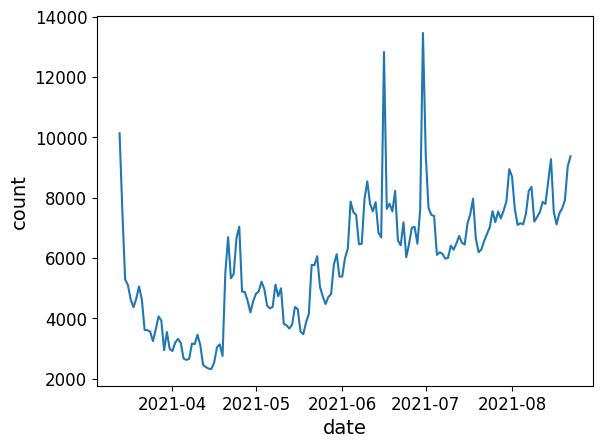

In [158]:
sns.lineplot(data=pd.DataFrame(interactions_df_unique_users_count, columns=['date', 'count']), x='date', y='count') 

Ага, очевидно, что каждый день есть у нас есть холодные пользователи. Это необходимо учесть в модели и по хорошему - придумать, что с ними делать

Посмотрим на обьекты

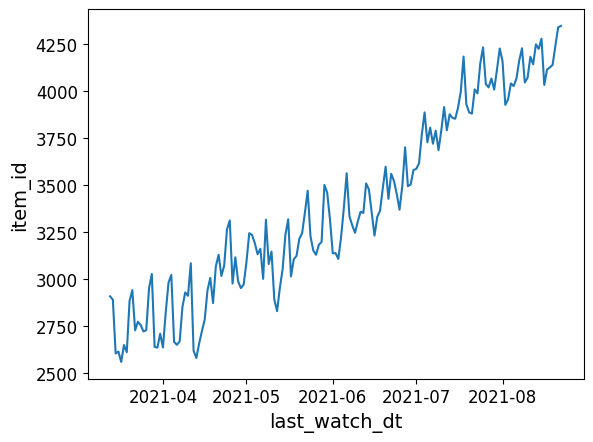

In [159]:
interactions_df_items_count = interactions_df.groupby('last_watch_dt').agg({'item_id': pd.Series.nunique}).reset_index().sort_values('last_watch_dt')
sns.lineplot(data=interactions_df_items_count, x='last_watch_dt', y='item_id');

In [160]:
interactions_df_unique_items_count = []
unique_items = set()

for date in sorted(interactions_df.last_watch_dt.unique()):
    date_unique_items = interactions_df[interactions_df.last_watch_dt == date].item_id.unique()
    interactions_df_unique_items_count.append((date, len(set(date_unique_items) - unique_items)))
    unique_items = unique_items.union(set(date_unique_items))
    
interactions_df_unique_items_count = pd.DataFrame(interactions_df_unique_items_count, columns=['date', 'count'])

<Axes: xlabel='date', ylabel='count'>

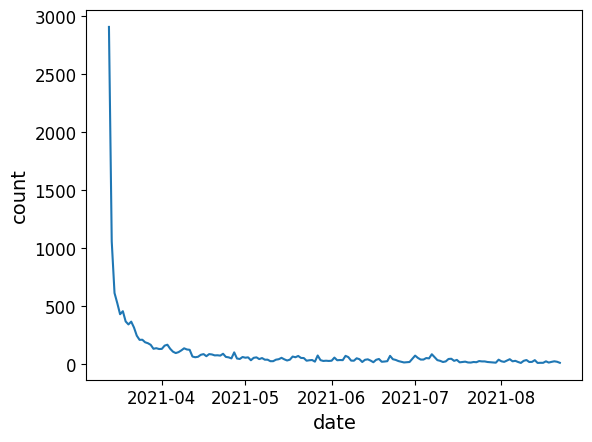

In [161]:
sns.lineplot(data=interactions_df_unique_items_count, x='date', y='count') 

<Axes: xlabel='date', ylabel='count'>

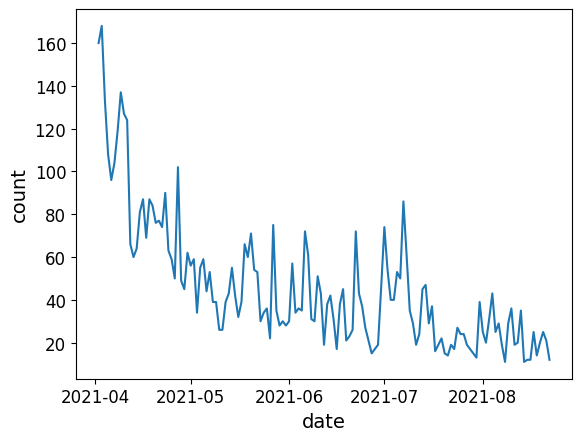

In [162]:
sns.lineplot(data=interactions_df_unique_items_count[interactions_df_unique_items_count.date > '2021-04-01'], x='date', y='count') 

Холодные объекты тоже есть, но их явно меньше

# Сохранение

In [163]:
users_df.to_csv('processed_users.csv', index=False)
items_df.to_csv('processed_items.csv', index=False)
interactions_df.to_csv('processed_interactions.csv', index=False)